In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
plt.style.use('bmh')
%matplotlib inline
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 從FMP網站的api下載示範股票aapl的財務數據，註冊後才可試用其它個股
income_statement = pd.read_json('https://financialmodelingprep.com/api/v3/income-statement/AAPL?period=quarter&apikey=demo')
ratios = pd.read_json('https://financialmodelingprep.com/api/v3/ratios/AAPL?period=quarter&apikey=demo')
enterprise_values = pd.read_json('https://financialmodelingprep.com/api/v3/enterprise-values/AAPL?period=quarter&apikey=demo')
key_metrics = pd.read_json('https://financialmodelingprep.com/api/v3/key-metrics/AAPL?period=quarter&apikey=demo')
financial_growth = pd.read_json('https://financialmodelingprep.com/api/v3/financial-growth/AAPL?period=quarter&apikey=demo')

# 把這5份財務指標合成1份
one = pd.merge( income_statement, ratios, on ='date') 
two = pd.merge( enterprise_values, key_metrics, on ='date')
four = pd.merge( one, two, on ='date')
df = pd.merge( four, financial_growth, on= 'date')

# 資料清理
df.set_index('date',inplace=True) 
df = df.drop(['symbol','symbol_x_x','symbol_x_y','symbol_y_x','symbol_y_y','fillingDate','acceptedDate' ,'period','link','finalLink'], axis=1).sort_index()
df = df[~df.isin([0])].dropna(axis=1)

df.to_csv('example.csv')
df = pd.read_csv('example.csv',index_col='date')
df.tail()

,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,operatingExpenses,costAndExpenses,depreciationAndAmortization,ebitda,ebitdaratio,operatingIncome,operatingIncomeRatio,totalOtherIncomeExpensesNet,incomeBeforeTax,incomeBeforeTaxRatio,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,currentRatio_x,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,netProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,netIncomePerEBT,ebtPerEbit,ebitPerRevenue,...,priceToSalesRatio_y,pocfratio,pfcfRatio,pbRatio,ptbRatio,evToSales,enterpriseValueOverEBITDA,evToOperatingCashFlow,evToFreeCashFlow,earningsYield,freeCashFlowYield,debtToEquity,debtToAssets,netDebtToEBITDA,currentRatio_y,incomeQuality,researchAndDdevelopementToRevenue,capexToOperatingCashFlow,capexToRevenue,capexToDepreciation,grahamNumber,roic,returnOnTangibleAssets,grahamNetNet,workingCapital,netCurrentAssetValue,averageReceivables,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover_y,payablesTurnover_y,inventoryTurnover_y,roe,capexPerShare,receivablesGrowth,inventoryGrowth,assetGrowth
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-30,58015000000,36194000000,21821000000,0.376127,3948000000,4458000000,8406000000,44600000000,3040000000,16455000000,0.283634,13415000000,0.231233,378000000,13793000000,0.237749,11561000000,0.199276,2.48,2.48,4704945000,4736949000,1.315382,1.014983,0.405110,94.906921,49.252915,144.159835,307.003785,-212.096865,0.376127,0.231233,0.237749,0.199276,0.033804,0.109210,0.055566,0.838179,1,0.237749,...,16.593619,86.300206,109.494859,9.093886,9.093886,17.674684,62.315211,91.922617,116.628389,0.012009,0.009133,2.230663,0.690466,3.811486,1.315382,0.964882,0.068051,4.720694,24.551418,1.286500,35.269585,0.055566,0.033804,-30.242702,29574000000,-112792000000,18027500000,37777000000,4490500000,94.906921,307.003785,49.252915,3.845873,1.188910,7.410729,0.109210,0.502238,-0.165514,-0.020850,-0.084879
2019-06-29,53809000000,33582000000,20227000000,0.375904,4257000000,4426000000,8683000000,42265000000,2933000000,14477000000,0.269044,11544000000,0.214537,367000000,11911000000,0.221357,10044000000,0.186660,2.22,2.20,4660175000,4691759000,1.504649,1.212454,0.563297,95.969447,36.465219,132.434667,316.448544,-220.479096,0.375904,0.214537,0.221357,0.186660,0.031169,0.104130,0.051222,0.843254,1,0.221357,...,18.159518,83.976065,101.405718,10.130479,10.130479,19.050354,70.807522,88.095608,106.380292,0.010279,0.009861,2.340788,0.700669,3.311114,1.504649,1.158503,0.079113,5.818000,26.904500,1.466500,31.681593,0.051222,0.031169,-25.509879,45269000000,-90810000000,17559000000,37113000000,3726000000,95.969447,316.448544,36.465219,3.803294,1.153426,10.009538,0.104130,0.429168,-0.062115,-0.313063,-0.057775
2019-09-28,64040000000,39727000000,24313000000,0.379653,4110000000,4578000000,8688000000,48415000000,3179000000,18804000000,0.293629,15625000000,0.243988,502000000,16127000000,0.251827,13686000000,0.213710,3.05,3.03,4617834000,4648913000,1.540126,1.168041,0.462022,130.668176,37.724721,168.392897,424.802779,-294.134603,0.379653,0.243988,0.251827,0.213710,0.040429,0.151247,0.069275,0.848639,1,0.251827,...,17.958644,57.763514,67.126105,12.709658,12.709658,18.789734,63.991414,60.436693,70.232566,0.011900,0.014897,2.741004,0.732692,2.830408,1.540126,1.454771,0.064179,7.169607,23.060857,1.144761,36.148202,0.069275,0.040429,-27.767022,57101000000,-85209000000,21948000000,45673500000,4101500000,130.668176,424.802779,37.724721,2.793335,0.859222,9.675353,0.151247,0.601364,0.620441,0.223845,0.050512
2019-12-28,91819000000,56602000000,35217000000,0.383548,4451000000,5197000000,9648000000,66250000000,2816000000,28385000000,0.309141,2556

In [3]:
# 爬取歷史股票
close = pd.read_json('https://financialmodelingprep.com/api/v3/historical-price-full/AAPL?serietype=line&apikey=demo')['historical']
price = pd.DataFrame(columns= ['date','price'],index=range(len(close)))
for i in range(len(close)):
    price['date'][i] = close[i]['date']
    price['price'][i] = close[i]['close']
price['date'] = pd.to_datetime(price['date']) 
price = price.set_index('date')
price = price.sort_index()

# 只抓季報公佈日期前的最後一日收盤價，再併入df裡
df['price'] = 0.
for i in range(len(df)):
    df['price'][i] = price.loc[:df.index[i]][-1:].values[0][0]
df['gain_or_loss'] = np.where(df['price'].pct_change() > 0, 1, 0)
df.tail()

,revenue,costOfRevenue,grossProfit,grossProfitRatio,researchAndDevelopmentExpenses,generalAndAdministrativeExpenses,operatingExpenses,costAndExpenses,depreciationAndAmortization,ebitda,ebitdaratio,operatingIncome,operatingIncomeRatio,totalOtherIncomeExpensesNet,incomeBeforeTax,incomeBeforeTaxRatio,netIncome,netIncomeRatio,eps,epsdiluted,weightedAverageShsOut,weightedAverageShsOutDil,currentRatio_x,quickRatio,cashRatio,daysOfSalesOutstanding,daysOfInventoryOutstanding,operatingCycle,daysOfPayablesOutstanding,cashConversionCycle,grossProfitMargin,operatingProfitMargin,pretaxProfitMargin,netProfitMargin,returnOnAssets,returnOnEquity,returnOnCapitalEmployed,netIncomePerEBT,ebtPerEbit,ebitPerRevenue,...,pfcfRatio,pbRatio,ptbRatio,evToSales,enterpriseValueOverEBITDA,evToOperatingCashFlow,evToFreeCashFlow,earningsYield,freeCashFlowYield,debtToEquity,debtToAssets,netDebtToEBITDA,currentRatio_y,incomeQuality,researchAndDdevelopementToRevenue,capexToOperatingCashFlow,capexToRevenue,capexToDepreciation,grahamNumber,roic,returnOnTangibleAssets,grahamNetNet,workingCapital,netCurrentAssetValue,averageReceivables,averagePayables,averageInventory,daysSalesOutstanding,daysPayablesOutstanding,daysOfInventoryOnHand,receivablesTurnover_y,payablesTurnover_y,inventoryTurnover_y,roe,capexPerShare,receivablesGrowth,inventoryGrowth,assetGrowth,price,gain_or_loss
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-03-30,58015000000,36194000000,21821000000,0.376127,3948000000,4458000000,8406000000,44600000000,3040000000,16455000000,0.283634,13415000000,0.231233,378000000,13793000000,0.237749,11561000000,0.199276,2.48,2.48,4704945000,4736949000,1.315382,1.014983,0.405110,94.906921,49.252915,144.159835,307.003785,-212.096865,0.376127,0.231233,0.237749,0.199276,0.033804,0.109210,0.055566,0.838179,1,0.237749,...,109.494859,9.093886,9.093886,17.674684,62.315211,91.922617,116.628389,0.012009,0.009133,2.230663,0.690466,3.811486,1.315382,0.964882,0.068051,4.720694,24.551418,1.286500,35.269585,0.055566,0.033804,-30.242702,29574000000,-112792000000,18027500000,37777000000,4490500000,94.906921,307.003785,49.252915,3.845873,1.188910,7.410729,0.109210,0.502238,-0.165514,-0.020850,-0.084879,189.95,1
2019-06-29,53809000000,33582000000,20227000000,0.375904,4257000000,4426000000,8683000000,42265000000,2933000000,14477000000,0.269044,11544000000,0.214537,367000000,11911000000,0.221357,10044000000,0.186660,2.22,2.20,4660175000,4691759000,1.504649,1.212454,0.563297,95.969447,36.465219,132.434667,316.448544,-220.479096,0.375904,0.214537,0.221357,0.186660,0.031169,0.104130,0.051222,0.843254,1,0.221357,...,101.405718,10.130479,10.130479,19.050354,70.807522,88.095608,106.380292,0.010279,0.009861,2.340788,0.700669,3.311114,1.504649,1.158503,0.079113,5.818000,26.904500,1.466500,31.681593,0.051222,0.031169,-25.509879,45269000000,-90810000000,17559000000,37113000000,3726000000,95.969447,316.448544,36.465219,3.803294,1.153426,10.009538,0.104130,0.429168,-0.062115,-0.313063,-0.057775,197.92,1
2019-09-28,64040000000,39727000000,24313000000,0.379653,4110000000,4578000000,8688000000,48415000000,3179000000,18804000000,0.293629,15625000000,0.243988,502000000,16127000000,0.251827,13686000000,0.213710,3.05,3.03,4617834000,4648913000,1.540126,1.168041,0.462022,130.668176,37.724721,168.392897,424.802779,-294.134603,0.379653,0.243988,0.251827,0.213710,0.040429,0.151247,0.069275,0.848639,1,0.251827,...,67.126105,12.709658,12.709658,18.789734,63.991414,60.436693,70.232566,0.011900,0.014897,2.741004,0.732692,2.830408,1.540126,1.454771,0.064179,7.169607,23.060857,1.144761,36.148202,0.069275,0.040429,-27.767022,57101000000,-85209000000,21948000000,45673500000,4101500000,130.668176,424.802779,37.724721,2.793335,0.859222,9.675353,0.151247,0.601364,0.620441,0.223845,0.050512,218.82,1
2019-12-28,91819000000,56602000000,35217000000,0.383548,4451000000,5197000000,9648000000,66250000000,2816000000,28385000000,0.309141,25569000000,0.278472,349000000,25918000000,0.282

In [4]:
# 不照時間順序的方法：訓練集與測試集隨機取樣
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
df = df.tail(16) # 僅截取近4年16季的財報
train_data = df.iloc[:,:-3]
test_data = df.iloc[:,-1:]
train_x, test_x, train_y, test_y = train_test_split(train_data, test_data, test_size= 0.2, random_state= 4)
clf = RandomForestClassifier(max_depth= 16, n_estimators= 128)
model = clf.fit(train_x,train_y.astype('int'))
train_acc, test_acc = accuracy_score(train_y, model.predict(train_x), normalize=True), accuracy_score(test_y, model.predict(test_x), normalize=True)
print(f'\n訓練習準度{train_acc}\n測試集準度{test_acc}')
# print('roc_auc', roc_auc_score(test_y, model.predict( test_x)))  # 預測若全對會導致roc_auc無法計算，故會報錯。但完全算錯亦為過度擬合
feature_imp = pd.Series(clf.feature_importances_, index = train_data.columns).sort_values(ascending = False)
print(feature_imp[:10])
print(classification_report(test_y, model.predict(test_x)))


訓練習準度1.0
測試集準度0.75
minusCashAndCashEquivalents    0.059467
receivablesGrowth              0.058667
cashRatio                      0.045615
cashPerShare_x                 0.029600
priceSalesRatio                0.028364
grahamNumber                   0.027886
interestDebtPerShare           0.025562
daysOfInventoryOnHand          0.024436
addTotalDebt                   0.024000
priceToSalesRatio_x            0.023297
dtype: float64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.75      1.00      0.86         3

    accuracy                           0.75         4
   macro avg       0.38      0.50      0.43         4
weighted avg       0.56      0.75      0.64         4



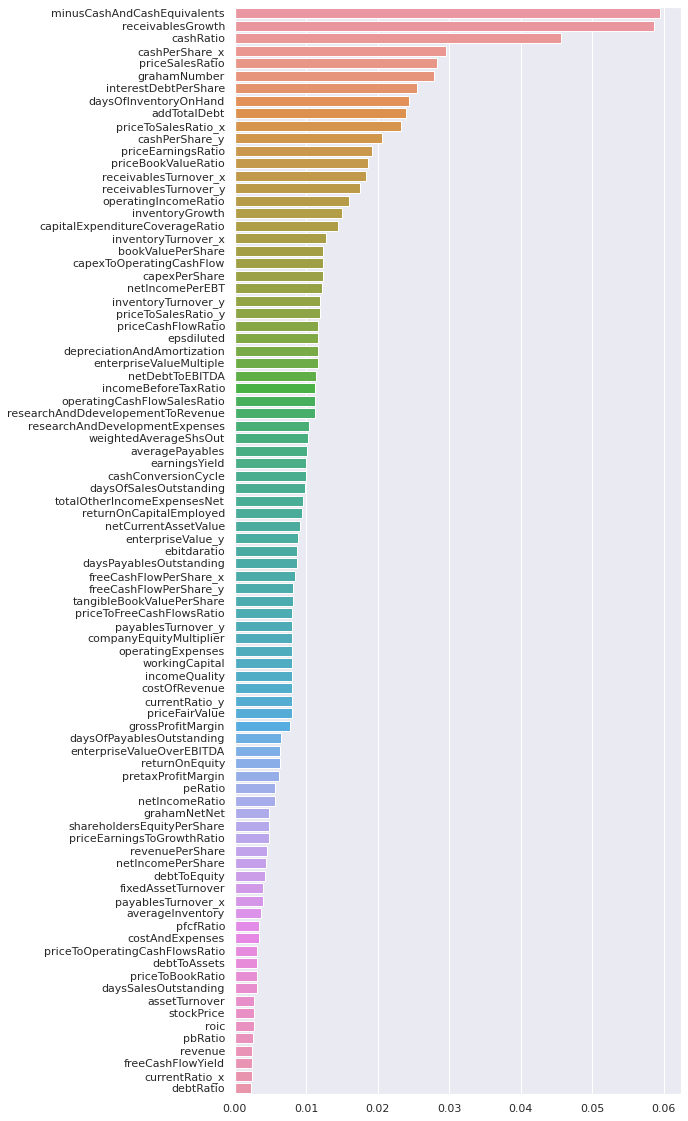

In [5]:
# 將特徵因子的重要性排序並圖像化
import seaborn as sns
feature_imp = pd.Series(clf.feature_importances_, index = train_data.columns).sort_values(ascending = False)
feature_imp = feature_imp[~feature_imp.isin([0])]
sns.set(rc={'figure.figsize':(8,20)}) 
sns.barplot(x= feature_imp, y= feature_imp.index)

In [6]:
# 照時間順序的方法：訓綀是取前13季，測試是取最近3季
train_data = df[df.index < "2019-09" ] # 13季 
test_data = df[df.index > "2019-09" ] # 3季

train_x = train_data.iloc[:,:-3].values
train_y = train_data.iloc[:,-1:].values
test_x = test_data.iloc[:,:-3].values
test_y = test_data.iloc[:,-1:].values

clf = RandomForestClassifier(max_depth= 16, n_estimators= 128) 
model = clf.fit(train_x,train_y)
print('訓練集的準度',accuracy_score(train_y, model.predict( train_x)))  # 在訓練集上的勝率
print('測試集的準度', accuracy_score(test_y, model.predict(test_x), normalize=True))  #print(accuracy_score(test_y, clf.predict( test_x)))
feature_imp = pd.Series(clf.feature_importances_, index = train_data.columns[:-3]).sort_values(ascending = False)
print(feature_imp[:10])
print(classification_report(test_y, model.predict(test_x)))

訓練集的準度 1.0
測試集的準度 0.6666666666666666
receivablesGrowth              0.042990
peRatio                        0.038320
totalOtherIncomeExpensesNet    0.033998
epsdiluted                     0.032787
eps                            0.032755
operatingCashFlowPerShare_x    0.027819
capexToRevenue                 0.026033
priceSalesRatio                0.025979
averageInventory               0.025801
interestDebtPerShare           0.024590
dtype: float64
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.67      1.00      0.80         2

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



#按時間順序與否的訓練，從accuracy_score看來並沒有差很多，但feature_importances_前10個僅有2個重疊

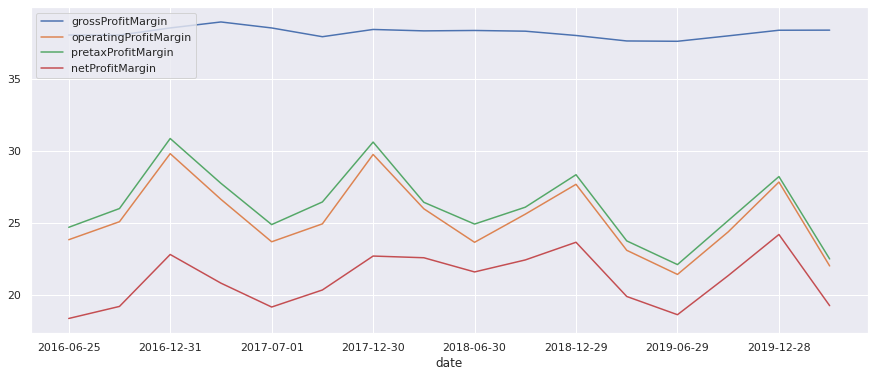

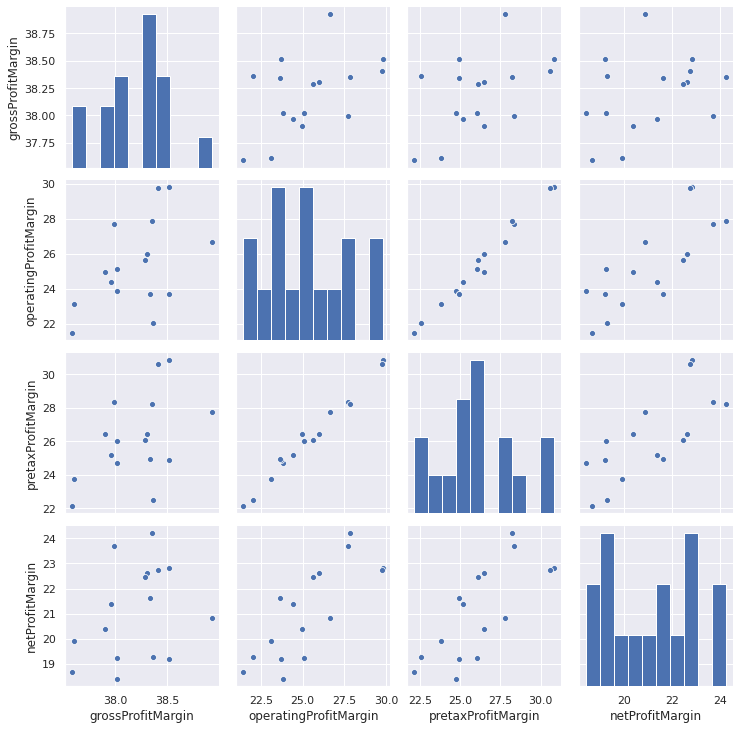

In [7]:
# 觀察各項利潤率的趨勢
margin_chart = df[['grossProfitMargin','operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin']]*100
margin_chart.plot(figsize=(15,6))
plt.legend(loc=2)
sns.pairplot(margin_chart)

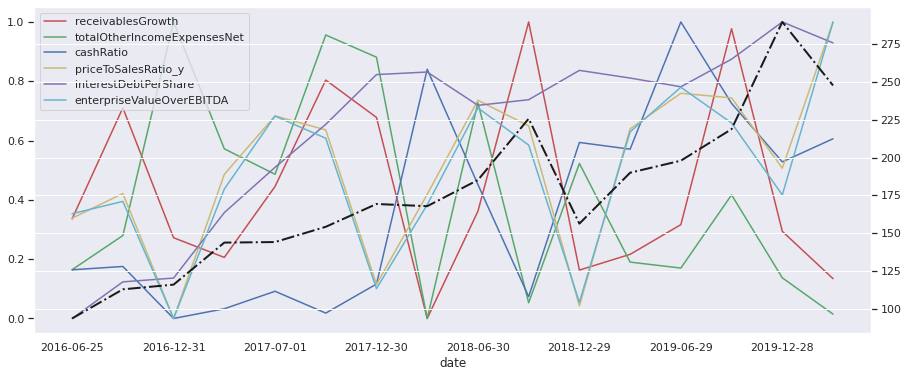

In [8]:
# 將兩種訓練採樣方式都出現的特徵值取出，再加上各訓練方法的前2大特徵因子，做成新的df
# 將特徵值限縮在0~1，觀察該特徵當期的值，目前處在過往歷史中偏高或偏低的位階，與股價(右邊y軸)比較其關連性
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()
features = df[['receivablesGrowth', 'totalOtherIncomeExpensesNet',
               'cashRatio', 'priceToSalesRatio_y',
               'interestDebtPerShare','enterpriseValueOverEBITDA', 
               ]]
df_minmax = pd.DataFrame(minmax.fit_transform(features),columns= features.columns)
df_minmax.plot(figsize=(15,6),color= ['r','g','b','y','m','c'])
df['price'].plot(secondary_y= True, ls='-.', c= 'k', lw= 2)

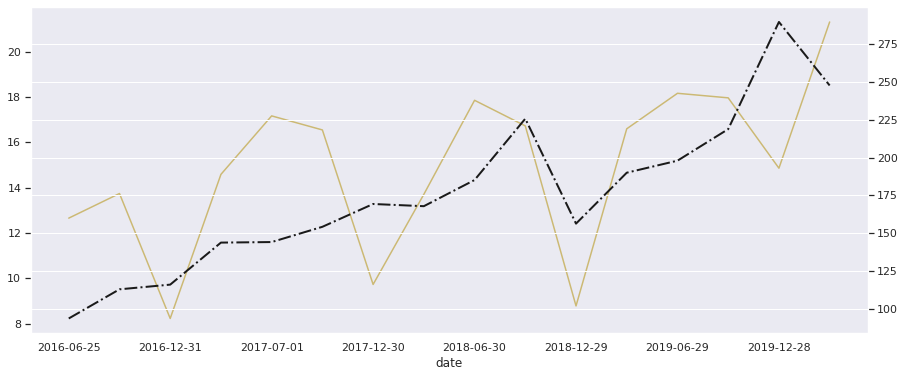

In [9]:
#排名第4的特徵因子「priceToSalesRatio_y」(黃色線)較相近，可做為日後的重點研究方向
features['priceToSalesRatio_y'].plot(figsize=(15,6),c = 'y')
df['price'].plot(secondary_y= True, ls='-.', c= 'k', lw= 2)